In [1]:
import pandas as pd
import numpy as np
from numpy import exp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from math import pi
from copy import deepcopy
import warnings
import logging
logging.getLogger('xgboost').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning, message=".*use_label_encoder.*")
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*ndim > 0 to a scalar.*")

# SADCO METHODS 

In [2]:
 
def L2_dist(A,B):
    x = A
    xsup = B
    ps = np.dot(A, B.T)
    nps,pps = ps.shape
    normx = np.sum(x**2,axis =1)
    normxsup = np.sum(xsup**2, axis = 1)
    ps = -2 * ps + normx[:, np.newaxis] + normxsup[np.newaxis, :]  
    E = np.sqrt(np.maximum(ps, 0))
    
    return E


def KNNenemyPoint(mindata,majdata):
    k_nNum = 1
    NT = mindata.shape[0]
    NTNT = majdata.shape[0]


    # for minority :
    
    minENNdist=np.ones((NT,k_nNum))*np.inf
    minenemykneigor = np.ones((NT,k_nNum))*np.inf

    # for majority
    majENNdist= np.ones((NTNT,k_nNum))*np.inf
    majenemykneigor = np.ones((NTNT,k_nNum))*np.inf

    # calculate nearest enemy from minoriy samples

    pd = L2_dist(mindata,majdata) # distance matrix betwen minority and majority
    for i in range(0,NT):
        
        d =deepcopy(pd[i,:])    # read row of distance matrix in each repeat
        min_id = []
       
        for k in range(0,k_nNum):
            id = np.argmin(d)
            d[id] = np.inf
            min_id.append(id)
        
        minENNdist[i, :] = pd[i, min_id]  
        minenemykneigor[i, :] = min_id 
   
 
    
    # calculate nearest enemy from majority samples
    pd = pd.T
    majmindistmax = pd

    for i in range(0,NTNT):
        
        d =deepcopy(pd[i,:])    # read row of  distance transpose matrix in each repeat
        min_id = []
        for k in range(0,k_nNum):
            id = np.argmin(d)
            d[id] = np.inf
            min_id.append(id)

        majENNdist[i,:] = pd[i,min_id]
        majenemykneigor[i,:] = min_id


    return minENNdist , minenemykneigor , majENNdist , majenemykneigor , majmindistmax
        
    
def calradious(i,ilabel,majlabel,minlabel,minENNdist,minenemykneigor,majENNdist,majenemykneigor):   
    # i index of sample in dataset
    # ilabel label of sample i 
    IR = majENNdist.shape[0] / minENNdist.shape[0]
    
    tha = 1 / (1 + np.exp(-(IR - 1)))  # Sigmoid-based threshold

    if ilabel == minlabel:
        nej =  int((minenemykneigor[i])[0])
        dij = minENNdist[i]
        jlabel = majlabel
        if i == majenemykneigor[nej]:
            dradius = dij * tha
            return dradius
        else:
            dt = calradious(nej, jlabel, majlabel, minlabel,minENNdist, minenemykneigor, majENNdist, majenemykneigor)

            dradius = dij - dt
            return dradius

    else:
        nej = int((majenemykneigor[i])[0])
        dij = majENNdist[i]
        jlabel = minlabel

        if i == minenemykneigor[nej]:
            dradius =  dij * (1 - tha)
            return dradius
        else:
            dt = calradious(nej, jlabel, majlabel, minlabel, minENNdist, minenemykneigor, majENNdist, majenemykneigor)
            dradius = dij - dt
            return dradius
import numpy as np

def normalizemeanstd(xapp, xtest=None, meanx=None, stdx=None):
    """
    Normalize inputs so that they have mean 0 and standard deviation 1.

    Parameters:
    - xapp: Training data (numpy array).
    - xtest: Test data (numpy array, optional).
    - meanx: Precomputed mean values (optional).
    - stdx: Precomputed standard deviation values (optional).

    Returns:
    - xapp: Normalized training data.
    - xtest: Normalized test data (if provided).
    - meanxapp: Mean values used for normalization.
    - stdxapp: Standard deviation values used for normalization.
    """

    tol = 1e-5  # Tolerance for near-zero standard deviation

    # Compute mean and standard deviation if not provided
    if meanx is None or stdx is None:
        meanxapp = np.mean(xapp, axis=0)  # Compute column-wise mean
        stdxapp = np.std(xapp, axis=0)    # Compute column-wise standard deviation
    else:
        meanxapp = meanx
        stdxapp = stdx

    # Handle near-zero standard deviations to avoid division errors
    stdxapp[np.abs(stdxapp) < tol] = 1  

    # Normalize training data
    xapp = (xapp - meanxapp) / stdxapp

    # Normalize test data if provided
    if xtest is not None and len(xtest) > 0:
        xtest = (xtest - meanxapp) / stdxapp
    else:
        xtest = None

    return xapp, xtest, meanxapp, stdxapp


def  unionSphere(data,dataradious):


    # Step 1: Calculate the pairwise Euclidean distance matrix
    pddist = L2_dist(data,data)

    # Step 2: Sort dataradious by the last column in descending order
    sortid = np.argsort(dataradious[:, -1])[::-1]  # Get indices for descending order
    sortdataradious = dataradious[sortid]  # Sort dataradious by radius (last column)


    # Initialize the flag array, marking which points have been processed
    flag = np.zeros(data.shape[0], dtype=int)

    # Step 3: Loop through each point and process it
    for i in range(sortdataradious.shape[0]):
        if flag[i] == 0:  # If the point has not been processed yet
            flag[i] = sortdataradious[i, 0]  # Mark it with its own identifier (from dataradious)

            # Get the indices of the remaining points that haven't been processed
            leftindex = np.arange(i + 1, sortdataradious.shape[0])
            leftindex = leftindex[flag[leftindex] == 0]  # Points that haven't been processed

            # Get the identifiers of the remaining unprocessed points
            leftunhandledid = (sortdataradious[leftindex, 0]).astype(int)


        
            # Calculate the distances from the current point to the remaining unprocessed points
            leftdist = pddist[int(sortdataradious[i, 0]), leftunhandledid] # فاصله ی نمونه های بررسی نشده تا مرکز انتخابی 

            # Find the indices of points that satisfy the distance condition
            includedset = np.where(leftdist <= sortdataradious[i, -1])[0] # befoe minus -1 it was 3 (last element of dataradious matrix )

            # If there are any included points, mark them with the current point's identifier
            if includedset.size > 0:
                flag[leftindex[includedset]] = flag[i]

    # Step 4: Create the "belongto" array to mark which group each point belongs to
    belongto = np.zeros(dataradious.shape[0], dtype=int)
    belongto[sortdataradious[:, 0].astype(int)] = flag

    # Update the dataradious with the new 'belongto' column
    dataradious = np.hstack([dataradious, belongto[:, np.newaxis]])  #****************************** table of information ****************************#

    
    
    
    #sorted_dataradious = dataradious[dataradious[:, -2].argsort()]
    

    return dataradious, pddist


def gnerandsphere(center, d, N, r):
    """
    Generates N random points within a d-dimensional sphere centered at `center` with radius `r`.

    Parameters:
    center (array-like): Coordinates of the sphere center.
    d (int): Dimension of the sphere.
    N (int): Number of points to generate.
    r (float): Radius of the sphere.

    Returns:
    np.ndarray: Nxd array of generated points.
    """
    # Generate random directions (unit vectors)
    random_directions = np.random.randn(N, d)
    random_directions /= np.linalg.norm(random_directions, axis=1, keepdims=True)  # Normalize to unit vectors

    # Generate random radii
    random_radii = r * np.random.rand(N, 1)

    # Scale unit vectors by random radii
    Y = random_directions * random_radii

    # Shift by the center
    Y = np.array(center) + Y

    return Y

# SADCO

In [3]:
import numpy as np

def GENERATEWITHSADCO(data_set_name, majlabel=1, minlabel=-1):
   

    data_all = np.loadtxt(data_set_name)
    data_all[:, :-1], _, meanxapp, stdxapp = normalizemeanstd(data_all[:, :-1])
    dim = data_all[:, :-1].shape[1]  # number of features (all columns except last, which is label)
    labx = data_all[:, -1]  # labels (last column)

    data_allmajority = data_all[labx == majlabel]
    data_allminority = data_all[labx == minlabel]
    IMratio = data_allmajority.shape[0] / data_allminority.shape[0]

    # Get enemy neighbors and distances using KNNenemyPoint (assumed defined elsewhere)
    minENNdist, minenemykneigor, majENNdist, majenemykneigor, majmindistmax = KNNenemyPoint(
        data_allminority[:, :-1], data_allmajority[:, :-1]
    )

    mindradious = []
    for i in range(data_allminority.shape[0]):
        ilabel = minlabel
        dradius = calradious(
            i, ilabel, majlabel, minlabel, minENNdist, minenemykneigor, majENNdist, majenemykneigor
        )
        mindradious.append([i, *data_allminority[i, :-1], dradius])

    data = data_allminority[:, :-1]
    radiouses = np.array(mindradious, dtype=object)

    # Merge spheres and calculate number of spheres and points in each sphere
    sorted_dataradious, pddist = unionSphere(data, radiouses)

    uncoveredpoint = np.unique(sorted_dataradious[:, -1])  # unique spheres
    numofsphere = []
    for j in uncoveredpoint:
        numofsphere.append(np.sum(sorted_dataradious[:, -1] == j))
    numofsphere = np.array(numofsphere)

    uncoveredpoint = np.array(uncoveredpoint, dtype=int)

    # Compute complexity measure
    complexitymeasure = len(uncoveredpoint) / data_allminority.shape[0]

    # Extract final centers and radii of spheres
    # Here uncoveredpoint is indices of unique spheres
    finalmincenters = sorted_dataradious[uncoveredpoint, 1:-2]  # centers of spheres
    finalminradius = sorted_dataradious[uncoveredpoint, -2]  # radii of spheres

    # Set complexity measure to 1 
    complexitymeasure = 1

    # Calculate oversample size (how many new samples to generate)
    oversamplesize = np.ceil(complexitymeasure * (data_allmajority.shape[0] - data_allminority.shape[0]))
    if oversamplesize < 1:
        oversamplesize = 1  # Make sure oversample size is at least 1

    # Define alpha and beta for weighting
    alpha = 1
    beta = 1

    finalminradius = np.asarray(finalminradius, dtype=float).reshape(-1)
    numofsphere = np.asarray(numofsphere, dtype=float).reshape(-1)

    # Compute pi and pj weights
    pi = np.exp(-alpha * finalminradius)
    pj = np.exp(-beta * numofsphere)

    pi = (pi + pj) / np.sum(pi + pj)

    # Calculate oversample sizes for each sphere
    suboversamplesizes = np.ceil(pi * oversamplesize)
    suboversamplesizes[suboversamplesizes < 1] = 1  # At least 1 sample per sphere

    # Generate new samples inside each sphere
    generatedX = []
    for i in range(len(uncoveredpoint)):
        # gnerandsphere(center, dim, N, radius) assumed defined elsewhere
        X = gnerandsphere(finalmincenters[i, :], dim, int(suboversamplesizes[i]), finalminradius[i])
        generatedX.append(X)

    generatedX = np.vstack(generatedX)

    return (
        data_allminority,
        data_allmajority,
        mindradious,
        uncoveredpoint,
        sorted_dataradious,
        finalmincenters,
        finalminradius,
        numofsphere,
        generatedX,
    )


# SADCO CYLINDER

In [4]:
def generate_samples(space_point ,d , density ,r , degree ):


          
        s = space_point + np.random.uniform(-1, 1, (density, d)) * r * degree

        return s



def point_to_line_distance(P, A, B):
    """
    Calculates the shortest distance from point P to the line defined by A and B.
    """
    P, A, B = np.asarray(P, dtype=float), np.asarray(A, dtype=float), np.asarray(B, dtype=float)
    d = B - A
    v = P - A
    d_norm_sq = np.dot(d, d)
    
    if d_norm_sq == 0:
        return np.linalg.norm(v)
    
    proj_d_v = np.dot(v, d) / d_norm_sq * d
    perp_vec = v - proj_d_v
    return np.linalg.norm(perp_vec)






def cylinder(data_allminority, data_allmajority, finalmincenters, finalminradius,generatedX, th  , density , degree ,keep=3, th_end=np.inf , limit = np.inf , use_enemy=True): 

    
    
   

    counter = 0 
    
    space_dim = finalmincenters.shape[1]
    dim = finalmincenters.shape[0]
    
    from_center1_to_center2 = {}
    from_sample_to_line = {}

    new_finalmincenters = []
    new_finalminradius = []



    for i, center1 in enumerate(finalmincenters):
        for j, center2 in enumerate(finalmincenters):
            if j > i:
                diff = center2 - center1
                from_center1_to_center2[(i, j)] = {"center1": center1, "center2": center2, "diff": diff,"index":-1}
    
                max_distance1, max_distance2 = -np.inf, -np.inf
                max_sample1, max_sample2 = None, None
                max_index1, max_index2 = None, None  # To store the indices of the maximum samples
                if use_enemy ==True : 
                    for idx, p in enumerate(data_allmajority[:, :-1]):  # Assuming last column is a label or not needed
                        distance = np.linalg.norm(p - center1) + np.linalg.norm(p - center2)  # Combined distance
        
                        if distance >= max_distance1:
                            max_distance2, max_sample2, max_index2 = max_distance1, max_sample1, max_index1
                            max_distance1, max_sample1, max_index1 = distance, p, idx
                        elif distance > max_distance2:
                            max_distance2, max_sample2, max_index2 = distance, p, idx
        
                    # Store the max samples, distances, and their indices
                    from_center1_to_center2[(i, max_index1)] = {"center1": center1, "center2": max_sample1, "diff": max_distance1,"index":max_index1}
                    from_center1_to_center2[(i, max_index2)] = {"center1": center1, "center2": max_sample2, "diff": max_distance2,"index":max_index2}                               
                    from_center1_to_center2[(j, max_index1)] = {"center1": center2, "center2": max_sample1, "diff": max_distance1,"index":max_index1}
                    from_center1_to_center2[(j, max_index2)] = {"center1": center2, "center2": max_sample2, "diff": max_distance2,"index":max_index2}      




    

       
    for idx, line_data in from_center1_to_center2.items():
        A, B = line_data["center1"], line_data["center2"]
        min_distance = min(
            point_to_line_distance(P, A, B) 
            for idx2, P in enumerate(data_allmajority[:, :-1]) if from_center1_to_center2[idx]["index"] != idx2
        )
        
        mid  = (A + B) / 2
        mid_left = (A+mid) / 2
        mid_right = (B+mid)/2

        from_sample_to_line[idx] = {
                'mid': mid,
                'mid_left': mid_left,
                'mid_right': mid_right,
                'rad': min_distance
        }
        
        if   keep==3:
            if min_distance>th and min_distance<th_end:
                new_finalmincenters.extend([mid, mid_left, mid_right])
                new_finalminradius.extend([min_distance] * 3)
                counter+=3
        if   keep==2:
            if min_distance>th and min_distance<th_end:
                new_finalmincenters.extend([mid, mid_left])
                new_finalminradius.extend([min_distance] *2)
                counter+=2


        if   keep==1:
            if min_distance>th and min_distance<th_end:
                new_finalmincenters.extend([mid])
                new_finalminradius.extend([min_distance])
                counter+=1

        if counter>=limit:
            break
   

            

    # Convert to NumPy arrays
    new_finalmincenters = np.array(new_finalmincenters, dtype=float)
    new_finalminradius = np.array(new_finalminradius, dtype=float).reshape(-1)

    
    
    new_generatedX = []


    for i in range(len(new_finalmincenters)):
        X = generate_samples(new_finalmincenters[i, :], space_dim , density , new_finalminradius[i] , degree)
        new_generatedX.append(X)
    
    new_generatedX = np.vstack(new_generatedX)  

    
    return finalmincenters , finalminradius , new_finalmincenters , new_finalminradius , new_generatedX , from_center1_to_center2 , from_sample_to_line

# plot method

In [5]:

def plot(data_allmajority , data_allminority , generatedX  , finalminradius , finalmincenters ) :
    # First Plot (No Changes)
    plt.figure(figsize=(8, 8))
    plt.scatter(data_allmajority[:, 0], data_allmajority[:, 1], color='blue', label='Majority')
    plt.scatter(data_allminority[:, 0], data_allminority[:, 1], color='red', label='Minority')
    plt.scatter(generatedX[:,0],generatedX[:,1],color ='black')
    
    # Draw circles around minority samples
    for center, radius in zip(finalmincenters, finalminradius):
        x, y = center
        circle = plt.Circle((x, y), radius, color='red', fill=False, linestyle='dashed')
        plt.gca().add_patch(circle)
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.axis('equal')
    plt.show()
    
    
    
    # **Second Plot (Improved for Better Visualization)**
    plt.figure(figsize=(10, 10))  # Bigger figure for better spacing
    
    # Scatter Plots with Better Visibility
    plt.scatter(data_allmajority[:, 0], data_allmajority[:, 1], color='blue', label='Majority', alpha=0.7, edgecolors='black')
    plt.scatter(data_allminority[:, 0], data_allminority[:, 1], color='red', label='Minority', alpha=0.8, edgecolors='black')
    plt.scatter(finalmincenters[:, 0], finalmincenters[:, 1], color='yellow', edgecolors='black', s=80, label='Centers')
    
    
    # Draw connections with more transparency
    for (i, j), line_data in from_center1_to_center2.items():
        start, end = np.array(line_data["center1"]), np.array(line_data["center2"])
        plt.plot([start[0], end[0]], [start[1], end[1]], 'purple', alpha=0.3, linestyle="dashed")  # Dashed, more transparent
    
        mid = (start + end) / 2  
        direction = end - start
        if np.linalg.norm(direction) == 0:
            continue  
    
        perp_vec = np.array([-direction[1], direction[0]])  
        perp_vec = perp_vec / np.linalg.norm(perp_vec)
    
        # **Shorter perpendicular lines**
        perp_length = from_sample_to_line[(i,j)]["rad"]
        end_point1 = mid + perp_vec * perp_length
        end_point2 = mid - perp_vec * perp_length  
    
        # **Thicker yellow perpendicular lines for better contrast**
        plt.plot([end_point1[0], end_point2[0]], [end_point1[1], end_point2[1]], color='yellow', linewidth=2.5, alpha=0.9)
    
    # Styling
    plt.xlabel("X-axis", fontsize=14)
    plt.ylabel("Y-axis", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)  # Light grid for better readability
    plt.show()



# data txt use_enemy = False

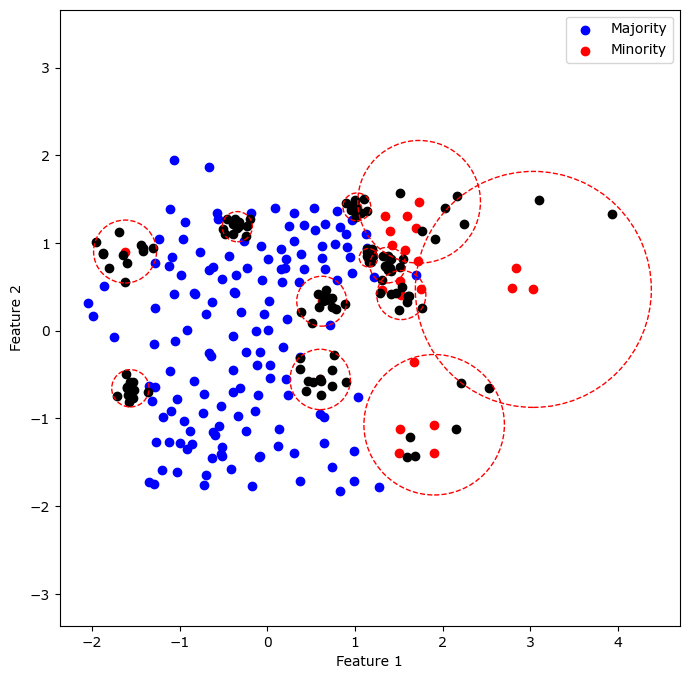

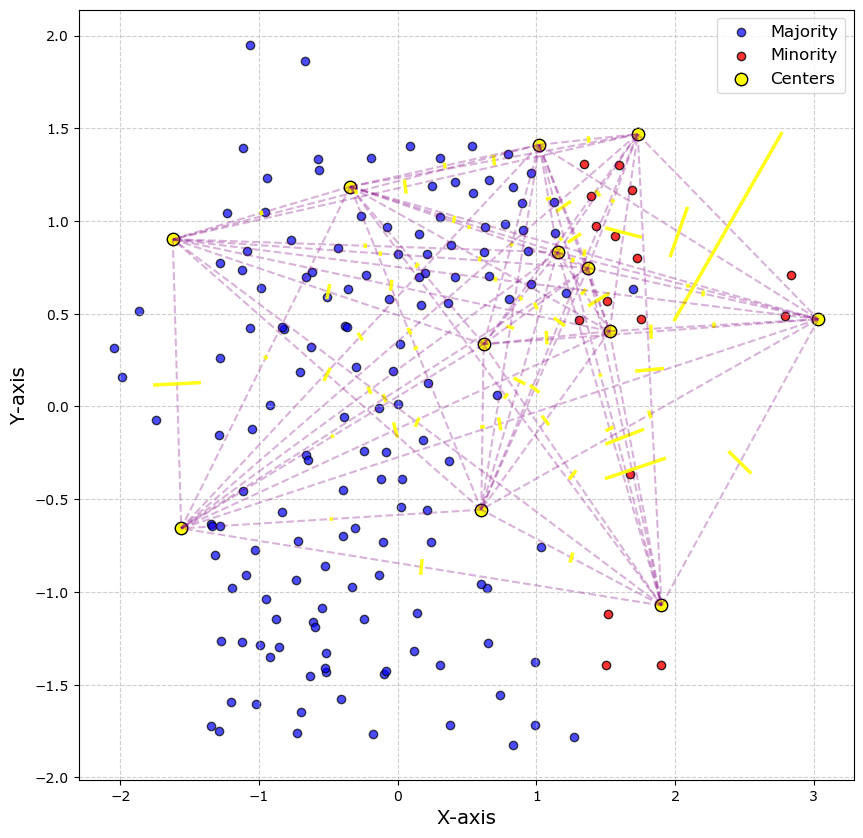

In [8]:
data_set_name = 'data_all.txt'
data_allminority , data_allmajority , mindradious , uncoveredpoint , sorted_dataradious , finalmincenters , finalminradius , numofsphere , generatedX = GENERATEWITHSADCO(data_set_name = data_set_name ,majlabel=1 , minlabel=-1)
finalmincenters , finalminradius , new_finalmincenters , new_finalminradius , new_generatedX, from_center1_to_center2 , from_sample_to_line =cylinder(data_allminority, data_allmajority, finalmincenters, finalminradius,generatedX,th=0 ,density=3 , degree=1 ,  th_end=np.inf, limit =np.inf ,use_enemy =False) 
plot(data_allmajority , data_allminority , generatedX  , finalminradius , finalmincenters )

# use_enemy = True

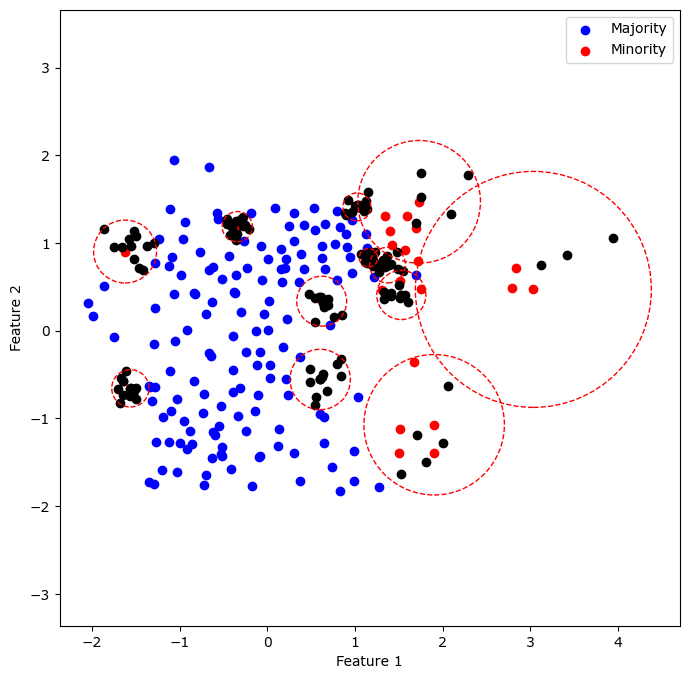

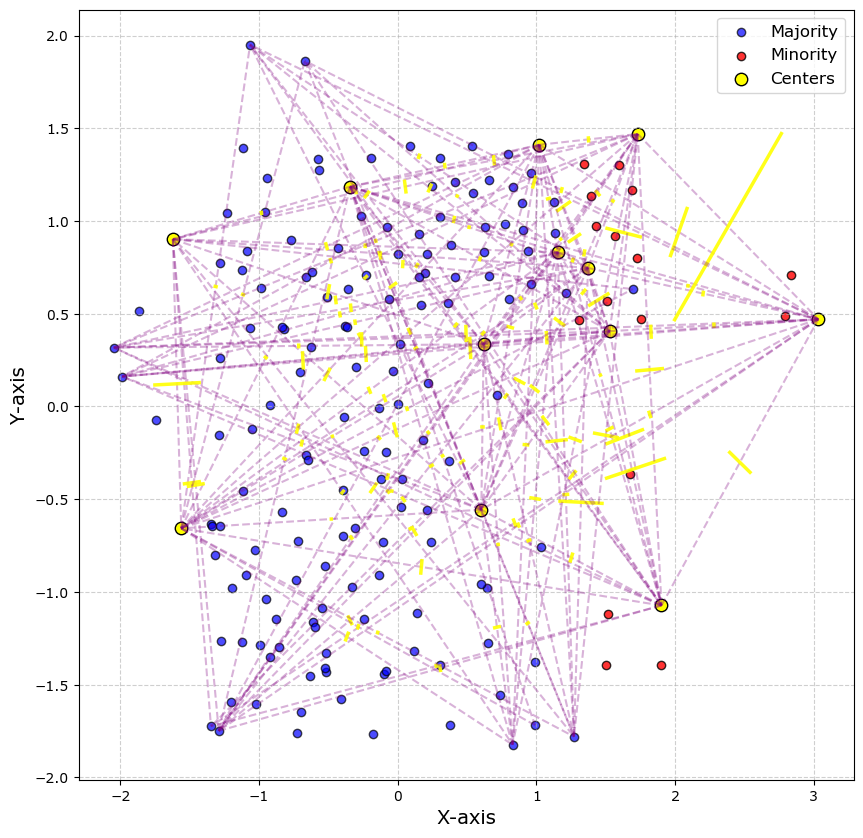

In [10]:

data_allminority , data_allmajority , mindradious , uncoveredpoint , sorted_dataradious , finalmincenters , finalminradius , numofsphere , generatedX = GENERATEWITHSADCO(data_set_name = data_set_name , majlabel=1 , minlabel=-1)
finalmincenters , finalminradius , new_finalmincenters , new_finalminradius , new_generatedX, from_center1_to_center2 , from_sample_to_line =cylinder(data_allminority, data_allmajority, finalmincenters, finalminradius,generatedX,th=0 ,density=3 , degree=1 ,  th_end=np.inf, limit =np.inf ,use_enemy =True) 
plot(data_allmajority , data_allminority , generatedX  , finalminradius , finalmincenters )